In [1]:
from time import sleep

import pybullet as p

import numpy as np

import h5py

def setUpWorld(initialSimSteps=10):

    p.resetSimulation()
    h=0.5
    #p.loadURDF("plane.urdf", [0, 0, -1], useFixedBase=True)
    p.loadURDF("plane.urdf", [0, 0, -2.0+h], useFixedBase=True)

    sleep(0.1)

    p.configureDebugVisualizer(p.COV_ENABLE_RENDERING,0)

    # Load Baxter

    baxterId = p.loadURDF("D:/bullet3_vr/examples/pybullet/gym/pybullet_data/baxter_common/baxter_description/urdf/toms_baxter.urdf", useFixedBase=True)

    #p.resetBasePositionAndOrientation(baxterId, [0.5, -0.8, 0.5], [0., 0., -1., -1.])
    p.resetBasePositionAndOrientation(baxterId, [0.0, -0.8, -0.00+h], [0., 0., -1., -1.])
    
    tableId = p.loadURDF("table_square/table_square.urdf", -1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000)
    
    #p.resetBasePositionAndOrientation(tableId, [0.5, -0.2, -0.2], [0., 0., -1., -1.])
    p.resetBasePositionAndOrientation(tableId, [0.0, -0.0, -0.7+h], [0., 0., -1., -1.])
    
    smallDuckId = p.loadURDF("duck_vhacd.urdf", 0.300000,0.600000,0.850000,0.000000,0.000000,0.000000,1.000000)
    
    #p.resetBasePositionAndOrientation(smallDuckId, [0.5, -0.2, 1.0], [0., 0., -1., -1.])
    p.resetBasePositionAndOrientation(smallDuckId, [0.0, 0.0, 0.2+h], [0., 0., -1., -1.])
    
    #smallCubeId = p.loadURDF("cube_small.urdf", 0.950000,-0.100000,0.700000,0.000000,0.000000,0.707107,0.707107)
    smallCubeId = p.loadURDF("cube_small.urdf",[0,0,0],globalScaling=0.5)
    #p.resetBasePositionAndOrientation(smallCubeId, [0.4, -0.2, 1.0], [0., 0., -1., -1.])
    p.resetBasePositionAndOrientation(smallCubeId, [0.1, 0.1, 0.2+h], [0., 0., -1., -1.])
   
    #bunnyId = p.loadSoftBody("bunny.obj",0.15)
    targetPosition = [0.0, 0.0, 0+h]
    p.addUserDebugText("TARGET", targetPosition, textColorRGB=[1,0,0], textSize=1.5)
    #p.resetBasePositionAndOrientation(bunnyId, [0.3, -0.2, 1.0], [0., 0., -1., -1.])
    
    p.addUserDebugLine([0,0,0+h],[1,0,0+h],[1,0,0],3)
    p.addUserDebugLine([0,0,0+h],[0,1,0+h],[0,1,0],3)
    p.addUserDebugLine([0,0,0+h],[0,0,1+h],[0,0,1],3)
    p.configureDebugVisualizer(p.COV_ENABLE_RENDERING,1)

    # Grab relevant joint IDs

    endEffectorId = 48 # (left gripper left finger)

    # Set gravity

    p.setGravity(0., 0., -10.)

    # Let the world run for a bit

    for _ in range(initialSimSteps):

        p.stepSimulation()

    return baxterId, tableId, endEffectorId



def euc_dist(posA, posB):

	dist = 0.

	for i in range(len(posA)):

		dist += (posA[i] - posB[i]) ** 2

	return dist



def getJointRanges(bodyId, includeFixed=False):

    lowerLimits, upperLimits, jointRanges, restPoses = [], [], [], []

    numJoints = p.getNumJoints(bodyId)

    for i in range(numJoints):

        jointInfo = p.getJointInfo(bodyId, i)

        if includeFixed or jointInfo[3] > -1:

            ll, ul = jointInfo[8:10]

            jr = ul - ll

            # For simplicity, assume resting state == initial state

            rp = p.getJointState(bodyId, i)[0]

            lowerLimits.append(-2)

            upperLimits.append(2)

            jointRanges.append(2)

            restPoses.append(rp)

    return lowerLimits, upperLimits, jointRanges, restPoses

In [2]:
def accurateIK(bodyId, endEffectorId, targetPosition, lowerLimits, upperLimits, jointRanges, restPoses, 

               useNullSpace=False, maxIter=10, threshold=1e-4):

    closeEnough = False

    iter = 0

    dist2 = 1e30

    numJoints = p.getNumJoints(bodyId)


    while (not closeEnough and iter<maxIter):

        if useNullSpace:

            jointPoses = p.calculateInverseKinematics(bodyId, endEffectorId, targetPosition,

                lowerLimits=lowerLimits, upperLimits=upperLimits, jointRanges=jointRanges, 

                restPoses=restPoses)

        else:

            jointPoses = p.calculateInverseKinematics(bodyId, endEffectorId, targetPosition)

    

        for i in range(numJoints):

            jointInfo = p.getJointInfo(bodyId, i)

            qIndex = jointInfo[3]

            if qIndex > -1:

                p.resetJointState(bodyId,i,jointPoses[qIndex-7])

        ls = p.getLinkState(bodyId,endEffectorId)    

        newPos = ls[4]

        #diff = [targetPosition[0]-newPos[0],targetPosition[1]-newPos[1],targetPosition[2]-newPos[2]]

        #dist2 = np.sqrt((diff[0]*diff[0] + diff[1]*diff[1] + diff[2]*diff[2]))
        
        dist2=euc_dist(newPos,targetPosition)
 
        print("dist2=",dist2)

        closeEnough = (dist2 < threshold)

        iter=iter+1

    print("iter=",iter)

    return jointPoses

In [3]:
def setMotors(bodyId, jointPoses):

    numJoints = p.getNumJoints(bodyId)

    for i in range(numJoints):

        jointInfo = p.getJointInfo(bodyId, i)

        #print(jointInfo)

        qIndex = jointInfo[3]

        if qIndex > -1:

            p.setJointMotorControl2(bodyIndex=bodyId, jointIndex=i, controlMode=p.POSITION_CONTROL,

                                    targetPosition=jointPoses[qIndex-7])
            
def getControlJointPoses(bodyId, jointPoses):
    controllableBaxterJoints = [34,35,36,37,38,40,41]
    numJoints = p.getNumJoints(bodyId)
    
    controlJointPoses =[]
    
    for i in range(numJoints):

        jointInfo = p.getJointInfo(bodyId, i)

        qIndex = jointInfo[3]

        if ((qIndex > -1) and (jointInfo[0] in controllableBaxterJoints)):
            
            controlJointPoses.append(jointPoses[qIndex-7])
            
    return controlJointPoses
            
def getHorizontalCameraUpVector(cameraEyePosition, cameraTargetPosition,scale =1.0):
    #given a straight line of view ,comutes a camera Up vector in case of horisontal camera. 
    #It is a required input for computation of the view Matrix and it is the most 
    # standard position for the camera in robotics
    vecGE = np.array(cameraTargetPosition)-np.array(cameraEyePosition)
    if(vecGE[2]==0.0):
        return [0.0,0.0,1.0]
    else:
        squaredVec = vecGE[0]*vecGE[0]+vecGE[1]*vecGE[1]
        return[-vecGE[2]*vecGE[0]/squaredVec,-vecGE[2]*vecGE[1]/squaredVec, 1.0]  
    
    
    
def accurateIK2(bodyId, endEffectorId, targetPosition, lowerLimits, upperLimits, jointRanges, restPoses, 

               useNullSpace=False, maxIter=10, threshold=1e-4,target_orn = None):

    if useNullSpace:

            jointPoses = p.calculateInverseKinematics(bodyId, endEffectorId, targetPosition,

                lowerLimits=lowerLimits, upperLimits=upperLimits, jointRanges=jointRanges, 

                restPoses=restPoses)

    else:
            #jointPoses = p.calculateInverseKinematics(kukaId,kukaEndEffectorIndex,pos,orn,jointDamping=jd)
            jointPoses = p.calculateInverseKinematics(bodyId, endEffectorId, targetPosition,target_orn)

    return jointPoses


    
    
def saveImage(img_arr, filename):
    #image as an output from getCameraImage
    w=img_arr[0] #width of the image, in pixels

    h=img_arr[1] #height of the image, in pixels
    #print(h)
    rgb=img_arr[2] #color data RGB

    dep=img_arr[3] #depth data

    np_img_arr = np.reshape(rgb, (h, w, 4))

    np_img_arr = np_img_arr*(1./255.)
    h5f = h5py.File(filename)
    h5f.create_dataset('data' , data=np_img_arr)
    h5f.close()
    
    
def saveCameraImage(filename):
    img_arr=p.getCameraImage(120,120,flags=p.ER_SEGMENTATION_MASK_OBJECT_AND_LINKINDEX,
                            renderer = p.ER_BULLET_HARDWARE_OPENGL)
    saveImage(img_arr,filename)

def saveData(filename,imgArr, ts, jointRecorder,cameraRecorder):
    #needs to be refactored and implemented
    return None

In [4]:
#tested, need to remove  renderer = p.ER_BULLET_HARDWARE_OPENGL
def getBaxterCameraImage(baxterId, cameraTargetPosition,renderer = p.ER_TINY_RENDERER):
    #computes rendered images from Baxter head camera
    #cameraTargetPosition is where in the world coordinates camera is looking at
    fov = 74
    width=120
    height=120

    aspect = width / height

    near = 0.02

    far = 300
    head_jointId = 9
    #print("CameraEyePosition:")
    #need to find a way to set baxter camera position based on his base position
    #cameraEyePosition =p.getLinkState(baxterId,head_jointId)[0]  
    cameraEyePosition = [0.0, -0.55, 1.15]
    #print(cameraEyePosition)
    #print("CameraTargetPosition:")
    #start = time.time()
    view_matrix = p.computeViewMatrix(cameraEyePosition, cameraTargetPosition, 
                                  getHorizontalCameraUpVector(cameraEyePosition,cameraTargetPosition))
    
    #print(time.time()-start)  #print(cameraTargetPosition)
    #print("Camera Up vector:")
    #print(getHorizontalCameraUpVector(cameraEyePosition,cameraTargetPosition))
    projection_matrix = p.computeProjectionMatrixFOV(fov, aspect, near, far)

    images_arr = p.getCameraImage(width, height, view_matrix, projection_matrix, shadow=True,flags = p.ER_SEGMENTATION_MASK_OBJECT_AND_LINKINDEX
                                  ,renderer = p.ER_TINY_RENDERER)

    #rgb_opengl= np.reshape(images[2], (height, width, 4))*1./255.

    #depth_buffer_opengl = np.reshape(images[3], [width, height])

    #depth_opengl = far * near / (far - (far - near) * depth_buffer_opengl)

    #seg_opengl = np.reshape(images[4], [width, height])*1./255.

    #time.sleep(1)
    return images_arr

In [5]:
import time
cid = p.connect(p.SHARED_MEMORY)

if (cid<0):

	p.connect(p.GUI)

p.resetSimulation()
baxterId, tableId, endEffectorId = setUpWorld()
lowerLimits, upperLimits, jointRanges, restPoses = getJointRanges(baxterId, includeFixed=False)
#for j in range(p.getNumJoints(baxterId)):

#	print(p.getJointInfo(baxterId,j))
#for j in range(p.getNumJoints(tableId)):

#	print(p.getJointInfo(tableId,j))

#i=49
#p.setJointMotorControl2(baxterId, i, p.POSITION_CONTROL, 
#                                    targetPosition=0.05, force=10)
#i=51
#p.setJointMotorControl2(baxterId, i, p.POSITION_CONTROL, targetPosition=-0.05, force=10)
            

In [ ]:
bunnyId = p.loadSoftBody("bunny.obj",0.15)
targetPosition = [0.0, 0.0, 0]
p.addUserDebugText("TARGET", targetPosition, textColorRGB=[1,0,0], textSize=1.5)

2.293210029602051


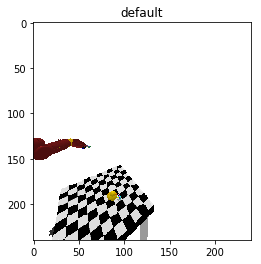

In [36]:
start = time.time()  
#ER_NO_SEGMENTATION_MASK
#ER_SEGMENTATION_MASK_OBJECT_AND_LINKINDEX
img_arr=p.getCameraImage(240,240,flags=p.ER_SEGMENTATION_MASK_OBJECT_AND_LINKINDEX
                         ,renderer = p.ER_TINY_RENDERER )
end = time.time()
print(end - start)
rgb=img_arr[2] #color data RGB

h=img_arr[0]
w=img_arr[1]

np_img_arr = np.reshape(rgb, (h, w, 4))
np_img_ar=np_img_arr*(1./255.)
#np_img_arr = np.uint8(np_img_arr)
import matplotlib.pyplot as plt

plt.imshow(np_img_arr)

plt.title('default')

plt.show()

(8.70051398468181e-18, -0.6116100020706654, 1.2496799901127815)
(-1.677918909370746e-08, 0.7677261740123964, 0.6407780596558275, -1.4004649828702753e-08)
2.5640294551849365


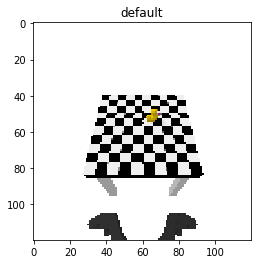

120


In [34]:
head_jointId = 9

llss =   p.getLinkState(baxterId,head_jointId)  
#position 
print(llss[0])
#orientation
print(llss[1])
#saveCameraImage('default_cam.h5')
start =time.time()
targetCameraPosition = p.getLinkState(tableId,0)[0]
baxterImg_arr = getBaxterCameraImage(baxterId, targetCameraPosition)
end = time.time()
print(end-start)
rgb=baxterImg_arr[2] #color data RGB

h=120
w=120

np_img_arr = np.reshape(rgb, (h, w, 4))
np_img_ar=np_img_arr*(1./255.)
#np_img_arr = np.uint8(np_img_arr)
import matplotlib.pyplot as plt

plt.imshow(np_img_arr)

plt.title('default')

plt.show()
#saveImage(baxterImg_arr,'baxter_cam.h5')
print(baxterImg_arr[1])

In [25]:
#p.setRealTimeSimulation(1)
controllers = [e[0] for e in p.getVREvents()]
targetPosition = [0.2, 0.0, -0.1]
p.addUserDebugText("TARGET", targetPosition, textColorRGB=[1,0,0], textSize=1.5)
camPos = [0.0, -0.55, 1.15]
p.addUserDebugLine(camPos,p.getLinkState(tableId,0)[0],[1,0,0],3)
upVec=getHorizontalCameraUpVector(camPos, p.getLinkState(tableId,0)[0])
fromVec = camPos
p.addUserDebugLine(camPos,[fromVec[0]+upVec[0], fromVec[1]+upVec[1],fromVec[2]+upVec[2]],[1,0,0],3)


6

In [12]:
p.resetSimulation()
baxterId, tableId, endEffectorId = setUpWorld()
lowerLimits, upperLimits, jointRanges, restPoses = getJointRanges(baxterId, includeFixed=False)

In [6]:
#red axes controller and world coinsides, green controller = -blue world
from jointRecorder import JointRecorder
jRec=JointRecorder('left')
jRec.start('joint_data')
from cameraRecorder import CameraRecorder
imgRecorder = CameraRecorder()
imgRecorder.start( 'video', 30, (120,120))
import math
import time
CONTROLLER_ID = 0
POSITION = 1
ORIENTATION = 2
THRESHOLD = .5
BUTTONS=6
ANALOG=3
controllerId = -1
while (controllerId<0):

	events = p.getVREvents()

	for e in (events):

		if (e[BUTTONS][2]==p.VR_BUTTON_IS_DOWN):

			controllerId = e[CONTROLLER_ID]

		#if (e[BUTTONS][32]==p.VR_BUTTON_IS_DOWN):

			#controllerId = e[CONTROLLER_ID]
#STATE_LOGGING_VIDEO_MP4
#logId = p.startStateLogging(p.STATE_LOGGING_GENERIC_ROBOT,"D:\bullet3_vr\examples\pybullet\notebooks\mylog.bin")
#logId = p.startStateLogging(p.STATE_LOGGING_VIDEO_MP4,"D:\bullet3_vr\examples\pybullet\notebooks\vidoelog.mp4")
print("Using controllerId="+str(controllerId))
timeStep = 0
succeed = False
Trajectories = []
savedStates=[]
count=1
while not succeed:
    p.stepSimulation()
    events = p.getVREvents()
    camData = p.getDebugVisualizerCamera()
    viewMat = camData[2]
    projMat = camData[3]
    #p.getCameraImage(256,256,viewMatrix=viewMat, projectionMatrix=projMat, renderer=p.ER_BULLET_HARDWARE_OPENGL)
    #implement functionality to record images
    #print(len(events))
    for e in (events):
            if(e[0] != controllerId):
                print("about to break...")
                break
            else:
                if( e[BUTTONS][32]==p.VR_BUTTON_IS_DOWN):
                    succeed = True
                sq_len = euc_dist(p.getLinkState(baxterId, endEffectorId)[0], e[POSITION])
                #print(sq_len)
                #print(e[ANALOG])
                #if control's trigger button was pushed
                #if(e[ANALOG]<0.5):
                    #close left gripper, right gripper is #27 -left finger and #29 -right
                #i=49
                #p.setJointMotorControl2(baxterId, i, p.POSITION_CONTROL, 
                #                    targetPosition=0.02*e[ANALOG], force=1)
                #i=51
                #p.setJointMotorControl2(baxterId, i, p.POSITION_CONTROL, targetPosition=-0.02*e[ANALOG], force=1)
                #else:
                    #i=49
                    #p.setJointMotorControl2(baxterId, i, p.POSITION_CONTROL, 
                    #                targetPosition=0.02, force=10)
                    #i=51
                    #p.setJointMotorControl2(baxterId, i, p.POSITION_CONTROL, targetPosition=-0.02, force=10)
                if (sq_len < THRESHOLD * THRESHOLD):# and (e[BUTTONS][2]==p.VR_BUTTON_IS_DOWN):
                    eef_pos = e[POSITION]
                    #eef_orn = p.getQuaternionFromEuler([0,-math.pi,0])
                    useNullSpace = False
                    #print("useNullSpace=",useNullSpace)
                    eef_orn=e[ORIENTATION]
                    #eef_orn = p.getQuaternionFromEuler([0,-math.pi,0])
                    jointPoses = accurateIK2(baxterId, endEffectorId, eef_pos, lowerLimits, upperLimits, jointRanges, restPoses, useNullSpace=useNullSpace, target_orn = eef_orn)
                    setMotors(baxterId, jointPoses)
                    #saveCameraImage('default_cam.h5')
                    targetCameraPosition = p.getLinkState(tableId,0)[0]
                    controlJointPoses = getControlJointPoses(baxterId, jointPoses)
                    ts = time.time()
                    jRec.save_ik_joint_poses(ts,controlJointPoses)
                    #savedStates.append(p.saveState())
                    p.saveBullet('logged'+str(count)+'.bullet')
                    count=count+1
                    #timestr = time.strftime("%Y%m%d-%H%M%S")

                    filename = "saveWorld" + str(count) + ".py"

                    p.saveWorld(filename)
                    
                    #start = time.time()                  
                    #img_arr=p.getCameraImage(640,480,flags=p.ER_SEGMENTATION_MASK_OBJECT_AND_LINKINDEX)
                    #end = time.time()
    #For testing of CameraRecorder
                    #baxterImg_arr = getBaxterCameraImage(baxterId, targetCameraPosition)
                    #w=baxterImg_arr[0] #width of the image, in pixels

                    #h=baxterImg_arr[1] #height of the image, in pixels
   
                    #rgb=baxterImg_arr[2] #color data RGB

                    #dep=baxterImg_arr[3] #depth data

                    #np_img_arr = np.reshape(rgb, (h, w, 4))
                    #np_img_arr = np.uint8(np_img_arr)
                    #print(np_img_arr.dtype)
                    #print(np_img_arr.size)
                    #print(np_img_arr.shape)
                    #np_img_arr = np_img_arr*(1./255.)
                    #imgRecorder.add_image(ts,np_img_arr)
    #For testing of CameraRecorder
                    #baxterImg_arr= baxterImg_arr + timeStep
                    #Trajectories.append(baxterImg_arr)
                    #saveImage(baxterImg_arr,'baxter_cam.h5')
                    #succeed = True
                    print("motors set ")
                    timeStep = timeStep +1
                    #if( e[BUTTONS][2]==p.VR_BUTTON_IS_DOWN):
                    #    succeed = True
                    
                i=49
                p.setJointMotorControl2(baxterId, i, p.POSITION_CONTROL, 
                                    targetPosition=0.02*e[ANALOG], force=500)
                i=51
                p.setJointMotorControl2(baxterId, i, p.POSITION_CONTROL, targetPosition=-0.02*e[ANALOG], force=500)    
                #else:
                    #for jointIndex in range(p.getNumJoints(kuka)):
                    #    p.setJointMotorControl2(kuka, jointIndex, p.POSITION_CONTROL,REST_JOINT_POS[jointIndex], 0)
    #sleep(0.1)
jRec.write_sample()
imgRecorder.clean_shutdown()
#p.stopStateLogging(logId)
print(savedStates)


Using controllerId=4
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors set 
motors 

In [10]:
p.resetSimulation()
p.restoreState(fileName='logged188.bullet')

error: Couldn't restore state.

In [12]:
p.resetSimulation()
bjects = [p.loadURDF("plane.urdf", 0.000000,0.000000,-1.500000,0.000000,0.000000,0.000000,1.000000)]
objects = [p.loadURDF("D:/bullet3_vr/examples/pybullet/gym/pybullet_data/baxter_common/baxter_description/urdf/toms_baxter.urdf", 0.000000,-0.800000,0.500000,0.000000,0.000000,0.707107,0.707107)]
ob = objects[0]
jointPositions=[ 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.001513, 0.000000, 0.004420, 0.041279, -0.025698, 0.000000, 0.000669, 0.003140, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000634, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -1.070402, -0.275633, -0.054873, -0.050001, -0.022875, 0.000000, 2.093900, 0.116167, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.011843, 0.000000, -0.012302, 0.000000, 0.000000, 0.000000, 0.000000 ]
for jointIndex in range (p.getNumJoints(ob)):
	p.resetJointState(ob,jointIndex,jointPositions[jointIndex])

objects = [p.loadURDF("table_square/table_square.urdf", 0.000000,0.000000,-0.200000,0.000000,0.000000,0.707107,0.707107)]
ob = objects[0]
jointPositions=[ 0.000000 ]
for jointIndex in range (p.getNumJoints(ob)):
	p.resetJointState(ob,jointIndex,jointPositions[jointIndex])

objects = [p.loadURDF("duck_vhacd.urdf", -0.028141,-0.071323,0.621837,-0.338406,0.680309,0.576185,-0.301118)]
objects = [p.loadURDF("cube_small.urdf", 0.101013,0.100339,0.452489,0.000045,-0.000011,0.717452,0.696608)]
p.setGravity(0.000000,0.000000,-10.000000)

In [ ]:

import matplotlib.pyplot as plt

import numpy as np
h5fread1 = h5py.File('default_cam.h5', 'r')
myNumpyArray1= h5fread1['data'][:]
#plt.subplot(4,2,3)

plt.imshow(myNumpyArray1)

plt.title('default')

plt.show()

h5fread2 = h5py.File('baxter_cam.h5', 'r')
myNumpyArray2= h5fread2['data'][:]
#plt.subplot(4,2,3)

plt.imshow(myNumpyArray2)

plt.title('baxter')

plt.show()

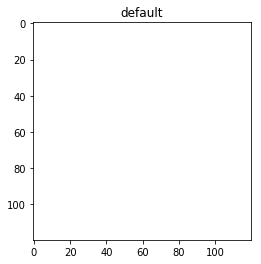

(0.0, 0.0, 0.40000002384185807)


4

In [17]:
import matplotlib.pyplot as plt

plt.imshow(np_img_arr)

plt.title('default')

plt.show()
cameraEyePosition = [0.0, -0.55, 1.15]
print(targetCameraPosition)
p.addUserDebugLine(cameraEyePosition,targetCameraPosition,[1,0,0],3)

In [ ]:
numJoints = p.getNumJoints(baxterId)

for i in range(numJoints):

        jointInfo = p.getJointInfo(baxterId, i)

        print(jointInfo)

In [ ]:
#should be tried first:
p.resetDebugVisualizerCamera(cameraDistance=7, cameraYaw=-94, cameraPitch=-14, cameraTargetPosition=[0.31,0.03,-1.16])
logId = p.startStateLogging(p.STATE_LOGGING_VIDEO_MP4,"videolog.mp4")